# Mesh

**GOAL**:  
The objective is to understand and visualize the vertical mesh structure at the equator.

---

## Imports

In [1]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

## Data

In [2]:
mesh = xr.open_dataset('../../data/model/orca05l75_domain_cfg_nemov5_10m.nc')
model = xr.open_dataset('../../data/model/nemo00_1m_201001_202212_Eq.nc')

## Calculating the bathymetry by hand

In [3]:
# Loop over selected y and x grid points
for y in [0, 100, 200, 300]:
    for x in [0, 100, 200, 200]:
        print("y =", y, "x =", x)

        # Get bottom level index at (y, x)
        levels = mesh.bottom_level.sel(y=y, x=x).values

        depth = 0.0  # Initialize total depth

        if levels > 0:
            # Sum layer thicknesses from level 0 to level-2
            for i in range(levels - 1):
                depth += mesh.e3t_1d.isel(nav_lev=i).values

            # Add last layer thickness from 3D field
            depth += mesh.e3t_0.sel(y=y, x=x).isel(nav_lev=levels - 1).values

        print("calculated depth =", depth)

        # Compare against actual bathymetry
        print("bathymetry =", mesh.bathy_metry.sel(y=y, x=x).values)
        print("################")

y = 0 x = 0
calculated depth = 0.0
bathymetry = 0.0
################
y = 0 x = 100
calculated depth = 0.0
bathymetry = 0.0
################
y = 0 x = 200
calculated depth = 0.0
bathymetry = 0.0
################
y = 0 x = 200
calculated depth = 0.0
bathymetry = 0.0
################
y = 100 x = 0
calculated depth = 2778.0
bathymetry = 2778.0
################
y = 100 x = 100
calculated depth = 4552.0
bathymetry = 4552.0
################
y = 100 x = 200
calculated depth = 4988.667323918189
bathymetry = 4988.667323918189
################
y = 100 x = 200
calculated depth = 4988.667323918189
bathymetry = 4988.667323918189
################
y = 200 x = 0
calculated depth = 3755.0
bathymetry = 3755.0
################
y = 200 x = 100
calculated depth = 0.0
bathymetry = 0.0
################
y = 200 x = 200
calculated depth = 4104.5
bathymetry = 4104.5
################
y = 200 x = 200
calculated depth = 4104.5
bathymetry = 4104.5
################
y = 300 x = 0
calculated depth = 0.0
bathymetry = 0.

## Vertical mesh at the equator

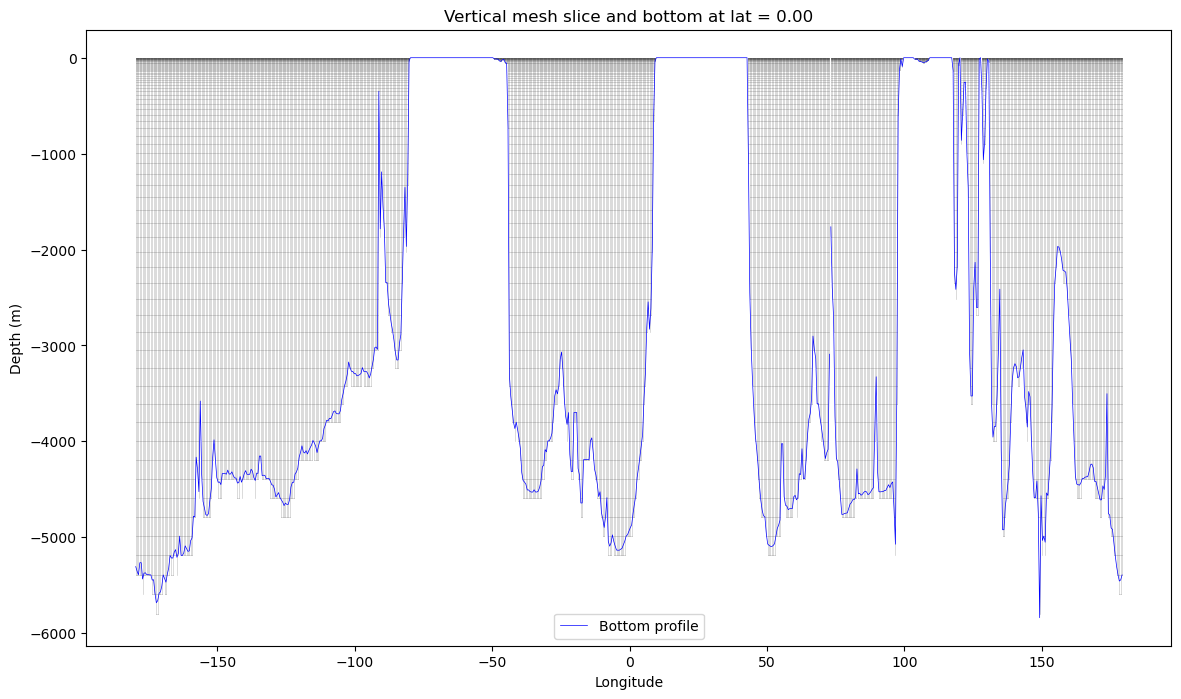

In [4]:
y = 249 # equator
nx = mesh.sizes["x"]
nlev = mesh.sizes["nav_lev"]

# Extract longitude and bottom level along the selected latitude
nav_lon = mesh.nav_lon.sel(y=y).values              # shape: (nx,)
bottom_levels = mesh.bottom_level.sel(y=y).values   # shape: (nx,)

# Extract 1D vertical layer thicknesses (constant across horizontal grid)
depth_grid = mesh.e3t_1d.values                     # shape: (nlev,)
depths = np.zeros(nx)                               # total depth at each x

# Compute bottom depth by summing vertical layer thicknesses
for x in range(nx):
    level = bottom_levels[x]
    if level > 0:
        # Sum regular layers up to level-1
        depths[x] = mesh.e3t_1d.isel(nav_lev=slice(0, level-1)).sum().values
        # Add thickness of last partial layer from 3D field
        depths[x] += mesh.e3t_0.sel(y=y, x=x).isel(nav_lev=level-1).values

# Remove longitudinal wraparound seam by setting discontinuity points to NaN
jump_value = 179.75
tol = 1e-5
indices = np.where(np.abs(nav_lon - jump_value) < tol)[0]
nav_lon[indices] = np.nan
depths[indices] = np.nan

# Precompute cumulative depth grid for each vertical level
depth_cumsum = -np.cumsum(np.tile(depth_grid[:, np.newaxis], (1, nx)), axis=0)  # shape: (nlev, nx)

# Create a boolean mask of valid vertical levels
valid_mask = np.zeros((nlev, nx), dtype=bool)
for x in range(nx):
    valid_mask[:bottom_levels[x], x] = True

# Apply the mask to depth_cumsum
depth_cumsum_masked = np.where(valid_mask, depth_cumsum, np.nan)

plt.figure(figsize=(14, 8))

# Plot horizontal lines (layers)
for lev in range(nlev):
    plt.plot(nav_lon, depth_cumsum_masked[lev, :], color='k', alpha=0.2, linewidth=0.5)

# Plot vertical lines (columns)
for x in range(nx):
    plt.plot([nav_lon[x]]*nlev, depth_cumsum_masked[:, x], color='k', alpha=0.2, linewidth=0.5)

# Plot bottom interface profile
plt.plot(nav_lon, -depths, color='blue', linewidth=0.5, label="Bottom profile")

# Axis labels and title
plt.xlabel("Longitude")
plt.ylabel("Depth (m)")
plt.title(f"Vertical mesh slice and bottom at lat = {mesh.nav_lat.sel(y=y).values.mean():.2f}")
plt.legend()
plt.show()

## Scatter plot of the temperature at the vertical slice

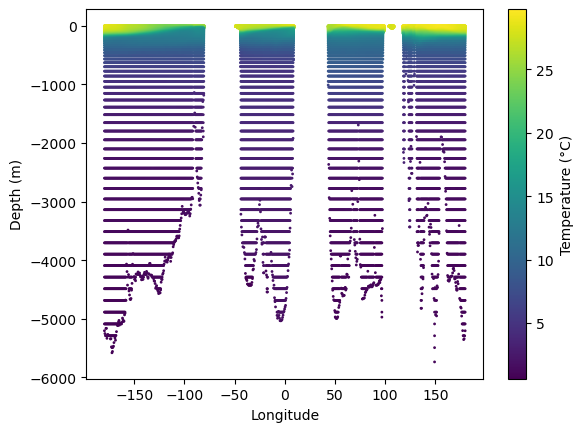

In [5]:
# Create 2D longitude array by repeating the 1D longitude values across depth levels
lon2d = np.tile(model.nav_lon_grid_T.values, (nlev, 1))[valid_mask]

# Initialize a 2D depth array with nominal depth values (shape: [nlev, nx])
depth2d = np.repeat(model.deptht.values[:, np.newaxis], nx, axis=1)

# Adjust depth at the bottom level using vertical thickness (e3t_0) from the mesh
for x in range(nx):
    level = bottom_levels[x]
    if level > 0:  # skip land or invalid points
        if level > 1:
            # Add the vertical thickness to the depth just above
            thickness = mesh.e3t_0.sel(y=y, x=x).isel(nav_lev=level - 1).values
            depth2d[level - 1, x] = depth2d[level - 2, x] + thickness
        else:
            # At the surface, just use the thickness
            depth2d[level - 1, x] = mesh.e3t_0.sel(y=y, x=x).isel(nav_lev=level - 1).values

# Flip depth to positive-downward convention and mask invalid points
depth1d = -depth2d[valid_mask]

# Extract valid temperature values
T = (model["to"].isel(time_counter=0, y_grid_T=0).values)
T1d = T[valid_mask]

# Plot temperature vs. longitude and depth
plt.scatter(lon2d, depth1d, c=T1d, s=1)
plt.xlabel("Longitude")
plt.ylabel("Depth (m)")
plt.colorbar(label="Temperature (°C)")
plt.show()